In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import empyrical as em  # most likely you will need to pip install this
from IPython.core.display import display, HTML
import numpy as np
from IPython.display import HTML

### Example close price df:
![close price df](close_price_df.png)

### Example port_value series:
![port_value_df](port_value.PNG)

In [2]:
def performance_eval(port_values, close_prices, initial_cash):
    '''
    Input: 1) A time series of portfolio value at end of day (close price * quantity)
           Please make sure the time index is in datetime format and excludes time 
           i.e. 2017-07-14 (you can use dt.date to extract the date)
           check above example
           
           2) A dataframe of close price at end of day (check above example)
 
    
    '''
    
    bdays_per_year = 256
    bdays_per_month = 20
    rolling_window = 20
    
    # resample to daily data
    close_prices['close_time'] = pd.to_datetime(close_prices['close_time'])
    close_prices = close_prices.resample('D', on='close_time').last()
    close_prices.index = close_prices.index.date
    close_prices = close_prices.drop(columns = ['close_time'])
    
    # make sure both time series are in the same time period
    close_prices = close_prices.reindex(port_values.index).ffill()
    
    yearly_pect_rtn = em.aggregate_returns(port_values.pct_change(), "yearly")
    monthly_pect_rtn = em.aggregate_returns(port_values.pct_change(), "monthly")
    
    annulized_rtn = np.power((port_values[-1] / initial_cash), (365/len(port_values))) - 1 
    
    accum_rtn = (port_values[-1] - initial_cash) / initial_cash
    
    # calculate sharpe ratio
    sqrt_bdays_per_year = int(np.sqrt(bdays_per_year))

    sharpe_ratio = (port_values.pct_change().mean() * bdays_per_year) / \
                        (port_values.pct_change().std() * sqrt_bdays_per_year)
    
    # calculate drawdowns
    drawdowns = (port_values / port_values.cummax()) - 1
    max_drawdown = drawdowns.iloc[(-np.abs(drawdowns.values)).argsort()][0]
    
    # calculate volatility
    daily_vola = close_prices['close'].diff().std()
    annualized_vola = np.sqrt(bdays_per_year) * daily_vola
    
    strategy_perc_returns = port_values.diff() / port_values.shift(1)
    strategy_cum_returns = strategy_perc_returns.cumsum()
    
    
    # plotting
    metric = pd.DataFrame(data={}, columns=["Backtest"], index=['Annualized Return', 'Cumulative Returns', 'Annual volatility',
                                                               'Sharpe Ratio', 'Max Drawdown'])


    metric.loc["Annualized Return", "Backtest"] = str(f'{annulized_rtn*100:.2f}%')
    metric.loc["Cumulative Returns", "Backtest"] = str(f'{accum_rtn*100:.2f}%')
    metric.loc["Annual volatility", "Backtest"] = str(f'{annualized_vola*100:.2f}%')
    metric.loc["Sharpe Ratio", "Backtest"] = str(f'{sharpe_ratio:.2f}')
    metric.loc["Max Drawdown", "Backtest"] = str(f'{max_drawdown*100:.2f}%')
    print(f"Start Date : {port_values.index[0]} ")
    print(f"End Date : {port_values.index[-1]} ")
    display(metric)

    plt.style.use('seaborn-talk')

    fig = plt.figure(figsize=(12, 15))
    ax = fig.add_subplot(511)
    ax.set_title('Equity Curve')
    ax.plot(port_values, linestyle='-', label='Equity Curve', linewidth=3.0, color='g')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(513)
    ax.set_title('Drawdowns')
    ax.fill_between(port_values.index,drawdowns,label = 'Drawdown', linestyle='-', linewidth=2.0, color='b')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(512)
    ax.set_title('Cumulative Returns')
    ax.plot(strategy_cum_returns, label='Cumulative Returns', linestyle='-', linewidth=3.0, color='g')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(514)
    rolling_vola = port_values.pct_change().rolling(rolling_window).std() # monthly
    ax.set_title(f'Rolling Volatility ({rolling_window} days)')
    ax.plot(rolling_vola, label=f'Rolling Volatility ({rolling_window} days)', linestyle='-', linewidth=2.0, color='orange')
    # ax.legend()
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(515)
    rolling_return = port_values.pct_change().rolling(rolling_window).mean() # monthly
    rolling_sharpe = rolling_return / rolling_vola
    ax.set_title(f'Rolling Sharpe Ratio ({rolling_window} days)')
    ax.plot(rolling_sharpe, label=f'Rolling Sharpe Ratio ({rolling_window} days)', linestyle='-', linewidth=2.0,color='orange')
    # ax.legend()
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])
    fig.tight_layout();
    
    # create time return table
    table = """
    <table class='table table-hover table-condensed table-striped'>
    <thead>
    <tr>
    <th style="text-align:right">Year</th>
    <th style="text-align:right">Jan</th>
    <th style="text-align:right">Feb</th>
    <th style="text-align:right">Mar</th>
    <th style="text-align:right">Apr</th>
    <th style="text-align:right">May</th>
    <th style="text-align:right">Jun</th>
    <th style="text-align:right">Jul</th>
    <th style="text-align:right">Aug</th>
    <th style="text-align:right">Sep</th>
    <th style="text-align:right">Oct</th>
    <th style="text-align:right">Nov</th>
    <th style="text-align:right">Dec</th>
    <th style="text-align:right">Year</th>
    </tr>
    </thead>
    <tbody>
    <tr>"""

    first_year = True
    first_month = True
    yr = 0
    mnth = 0
    for m, val in monthly_pect_rtn.iteritems():
        yr = m[0]
        mnth = m[1]

        if first_month:
            table += "<td align='right'><b>{}</b></td>\n".format(yr)
            first_month = False

        if first_year:  # pad empty months for first year if sim doesn't start in January
            first_year = False
            if mnth > 1:
                for i in range(1, mnth):
                    table += "<td align='right'>-</td>\n"

        table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

        if mnth == 12:  # check for dec, add yearly
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_pect_rtn[yr] * 100)
            table += "</tr>\n <tr> \n"
            first_month = True

    # add padding for empty months and last year's value
    if mnth != 12:
        for i in range(mnth + 1, 13):
            table += "<td align='right'>-</td>\n"
            if i == 12:
                table += "<td align='right'><b>{:+.1f}</b></td>\n".format(
                    yearly_pect_rtn[yr] * 100
                )
                table += "</tr>\n <tr> \n"
    table += "</tr>\n </tbody> \n </table>"

    print("\033[1m" + "Time Returns (monthly %)" + "\033[0m")
    display(HTML(table))
    
    
    # create holding period analysis
    df = pd.DataFrame(columns=range(1,len(monthly_pect_rtn)+1), index=[monthly_pect_rtn.index[0][0]])

    month_start = 0

    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Months</th>"

    for i in range(len(monthly_pect_rtn)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # get unique years
    monthly_index_set = set()
    for y, m in monthly_pect_rtn.index:
        if not y in monthly_index_set:
            monthly_index_set.add(y)

    years_unique = list(monthly_index_set)

    for y in years_unique: # Iterates years
        table += "<tr><th>{}</th>".format(y) # New table row

        for month_held in (range(1, len(monthly_pect_rtn)+1)):
            if month_held <= len(monthly_pect_rtn[month_start:month_start + month_held]):
                rtn = em.annual_return(monthly_pect_rtn[month_start:month_start + month_held], 'monthly' )
                table += "<td>{:+.0f}</td>".format(rtn * 100)

        table += "</tr>"   
        month_start += 1
    print("\033[1m" + "Holding Period Returns (%)" + "\033[0m")
    display(HTML(table))


## Example

In [3]:
df_2019 = pd.read_csv("ML_momentum_2019.csv")
df_2019['period_open'] = pd.to_datetime(df_2019['period_open'])
df_2019 = df_2019.set_index(df_2019['period_open'].dt.date)
df_2019.head()

,period_open,period_close,long_exposure,ending_value,ending_cash,transactions,starting_exposure,longs_count,short_value,returns,...,max_drawdown,sharpe,trading_days,alpha,beta,excess_return,period_label,benchmark_period_return,benchmark_volatility,max_leverage
period_open,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01 00:00:00+00:00,2019-01-01 23:59:00+00:00,0.0,-594.405,10566.962340,"[{'amount': -9, 'dt': Timestamp('2019-01-01 00...",0.000,0,-594.405,-0.002744,...,-0.002744,NaN,1,NaN,NaN,0.0,2019-01,0.0,NaN,0.059604
2019-01-02,2019-01-02 00:00:00+00:00,2019-01-02 23:59:00+00:00,0.0,-1952.262,11850.047472,"[{'amount': -81, 'dt': Timestamp('2019-01-02 0...",-594.405,0,-1952.262,-0.007498,...,-0.010221,-24.185666,2,NaN,NaN,0.0,2019-01,0.0,0.0,0.197242
2019-01-03,2019-01-03 00:00:00+00:00,2019-01-03 23:59:00+00:00,0.0,-3034.902,12907.371658,"[{'amount': -20, 'dt': Timestamp('2019-01-03 0...",-1952.262,0,-3034.902,-0.002558,...,-0.012753,-24.190675,3,NaN,NaN,0.0,2019-01,0.0,0.0,0.307411
2019-01-04,2019-01-04 00:00:00+00:00,2019-01-04 23:59:00+00:00,0.0,-4303.400,14061.847241,"[{'amount': -7, 'dt': Timestamp('2019-01-04 00...",-3034.902,0,-4303.400,-0.011550,...,-0.024155,-22.475039,4,NaN,NaN,0.0,2019-01,0.0,0.0,0.440992
2019-01-05,2019-01-05 00:00:00+00:00,2019-01-05 23:59:00+00:00,0.0,-5663.699,15282.712218,"[{'amount': -9, 'dt': Timestamp('2019-01-05 00...",-4303.400,0,-5663.699,-0.014289,...,-0.038099,-23.470808,5,NaN,NaN,0.0,2019-01,0.0,0.0,0.588802


In [4]:
port_values = df_2019['portfolio_value']
port_values

period_open
2019-01-01     9972.557340
2019-01-02     9897.785472
2019-01-03     9872.469658
2019-01-04     9758.447241
2019-01-05     9619.013218
                  ...     
2019-12-27    51567.645421
2019-12-28    50703.977891
2019-12-29    50691.140464
2019-12-30    50678.317083
2019-12-31    50669.121057
Name: portfolio_value, Length: 365, dtype: float64

In [5]:
close_prices = pd.read_csv("0_klines_ETHBTC_1m.csv")[['close_time', 'close']]
close_prices.head()

,close_time,close
0,2017-07-14 04:00:59.999,0.08
1,2017-07-14 04:01:59.999,0.08
2,2017-07-14 04:02:59.999,0.08
3,2017-07-14 04:03:59.999,0.08
4,2017-07-14 04:04:59.999,0.08


Start Date : 2019-01-01 
End Date : 2019-12-31 


,Backtest
Annualized Return,406.69%
Cumulative Returns,406.69%
Annual volatility,1.09%
Sharpe Ratio,1.56
Max Drawdown,-83.91%


Time Returns (monthly %)


Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2019,+21.1,-29.7,+12.2,+90.8,-22.6,+102.6,+57.6,+24.7,-16.7,+6.4,-1.4,+3.4,+408.1


Holding Period Returns (%)


Months,1,2,3,4,5,6,7,8,9,10,11,12
2019,+896,-62,-17,+506,+129,+718,+1221,+1232,+683,+587,+468,+408


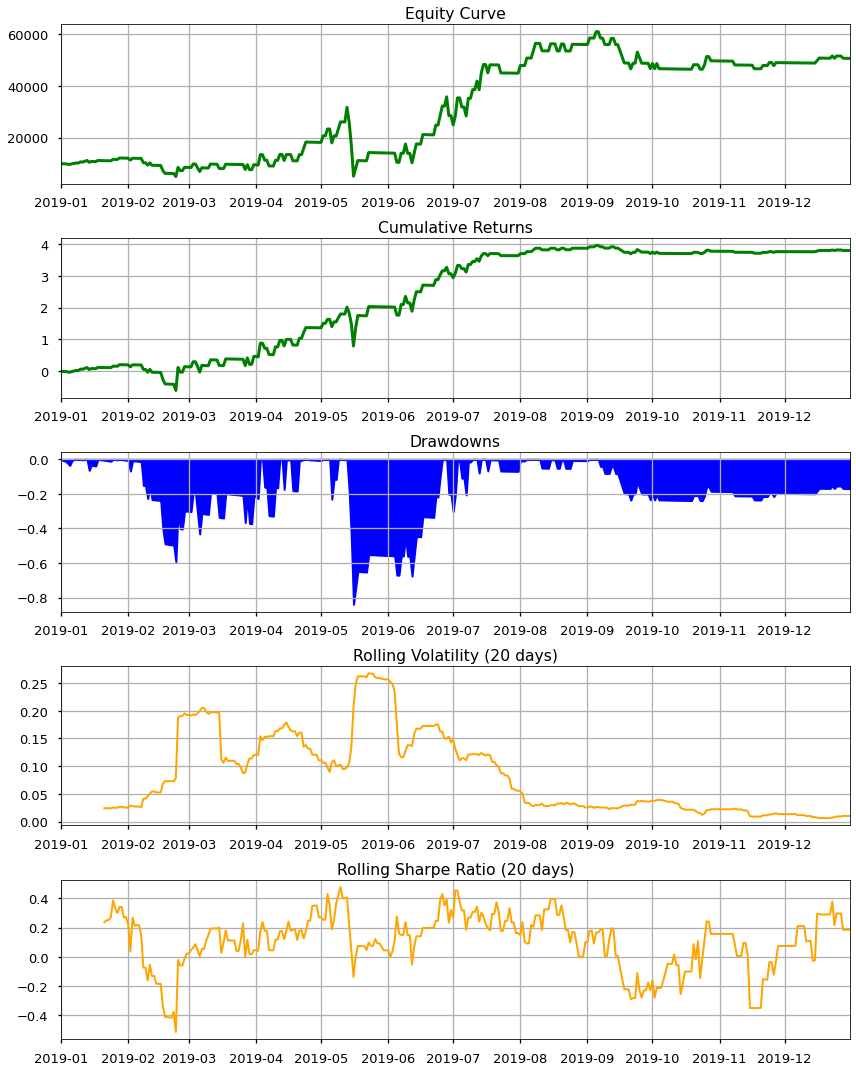

In [6]:
performance_eval(port_values, close_prices, 10000)